In [1]:
"""
July 7, 2020

Looking at results of the MCMC
"""


import ares
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
import distpy

print(matplotlib.__version__)

3.3.0


In [2]:
# Independent variables
# redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))
redshifts = np.sort(np.array([0.10165, 0.25,    0.35 ,   0.45,    0.575,   0.725,   0.875,   0.9,     ]))
#1.125, 1.65,    1.75,    2.25,    2.5,   ]))#  2.75,    3.5,  ]))

# 0.10165, 0.25,    0.35 ,   0.45,    0.575,   0.725,   0.875,   0.9,  1.125, 1.65,    1.75,    2.25,    2.5, 2.75,    3.5, 

Ms = np.linspace(7, 12, 60)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

# blob 2: the sfrd
blob_n2 = ['galaxy_sfrd']
blob_i2 = [('z', redshifts)]
blob_f2 = ['SFRD']

In [3]:
# anl = ares.analysis.ModelSet('MCMC_files/blob_test1')
# anl = ares.analysis.ModelSet('..\Cedar\savedFits/smf_14_07_13-54_4') #default, batch run
anl = ares.analysis.ModelSet('..\Cedar\savedFits/smf_20_07_08-20_0.0-5.0')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels

# anl.skip = 5000


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ..\Cedar\savedFits/                                                                    ####
#### prefix      : smf_20_07_08-20_0.0-5.0                                                                ####
#### N-d         : 8                                                                                      ####


In [8]:
from scipy.interpolate import interp1d

In [36]:
# data = anl.ExtractData(['galaxy_smf', 'galaxy_sfrd'])
x = np.linspace(0, 10, 10)
y = x*2 + 5

f = interp1d(x, y, kind='linear', fill_value=(-np.inf), bounds_error=False)

In [38]:
try:
    y0 = f(-11)
    print(y0)
except:
    print("nope")
    
y0 = f(11)

-inf


In [32]:
#     
# print(data['galaxy_smf'])
# print(data['galaxy_sfrd'][0])

print(data)

{'galaxy_smf': masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, -

60 60
1 2


ZeroDivisionError: integer division or modulo by zero

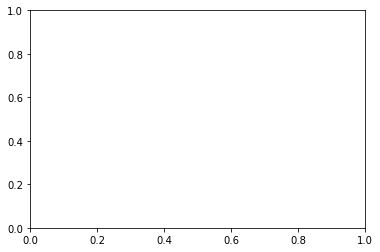

In [8]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 2.75
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [23]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]',

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

0 of 6000 chain elements ignored because of chain links with inf's/nan's.


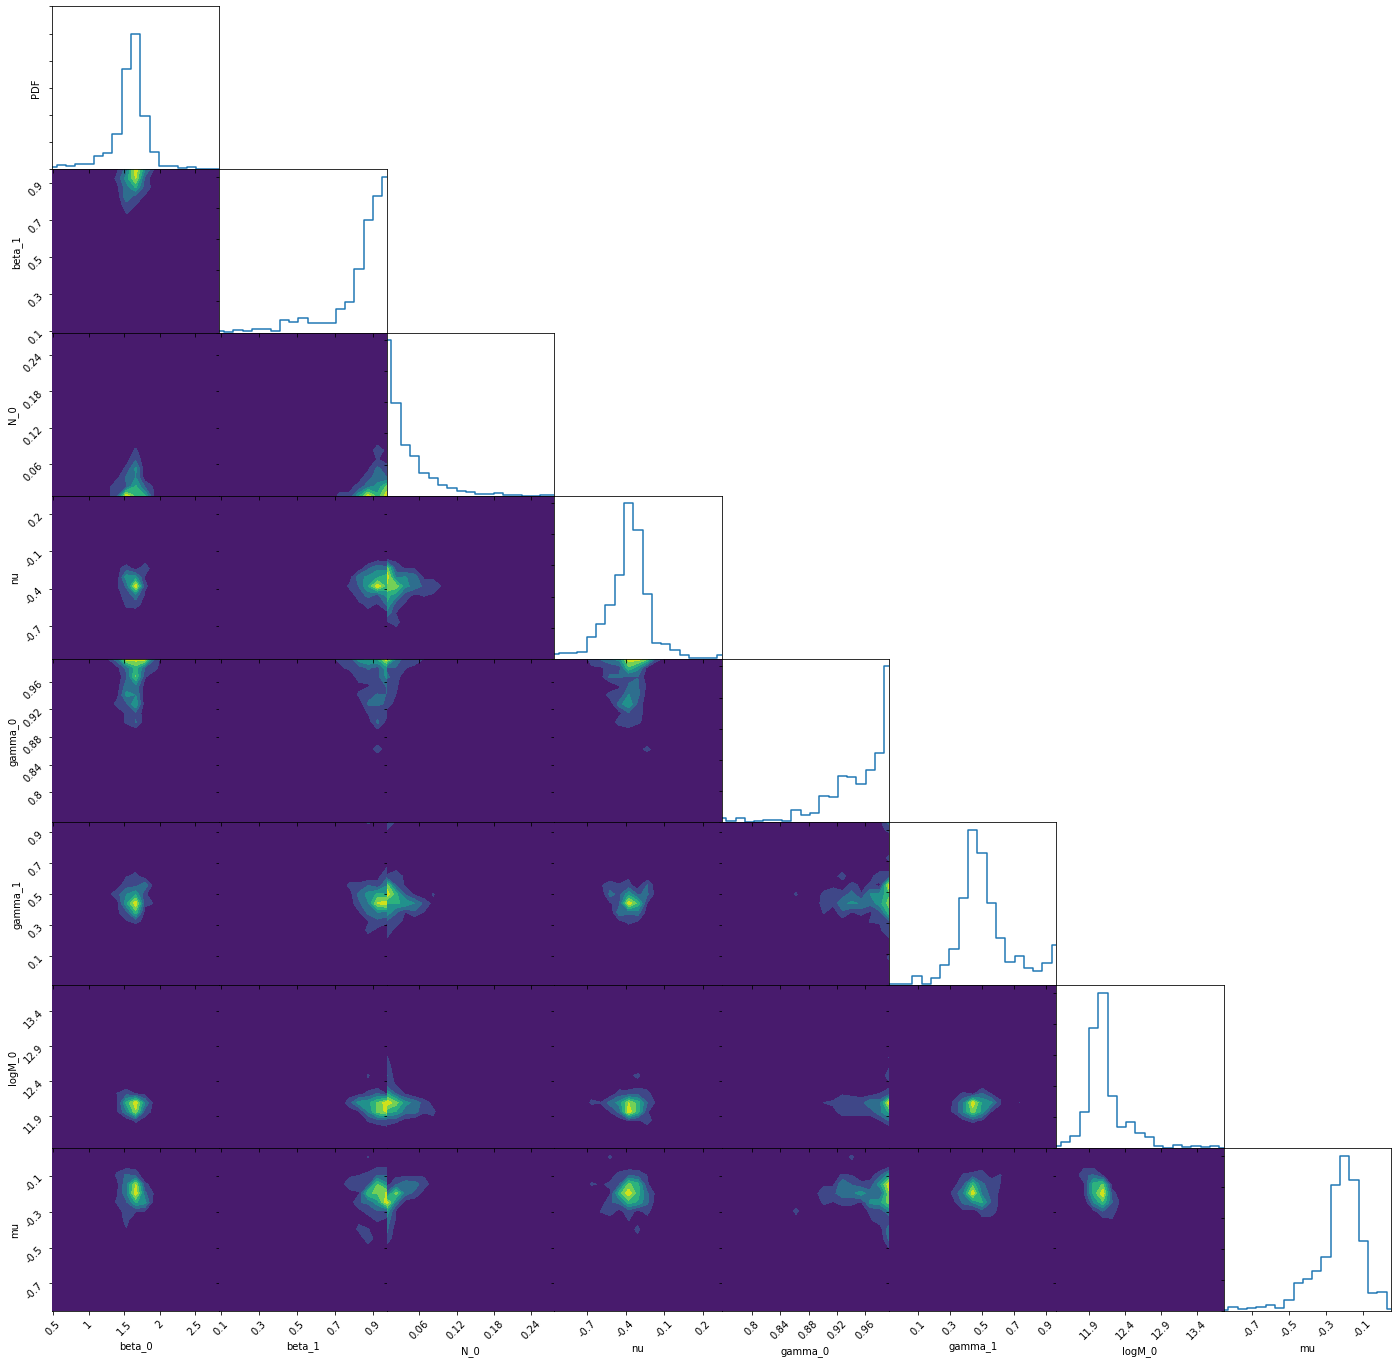

In [24]:

trig = anl.TrianglePlot(pars=params)

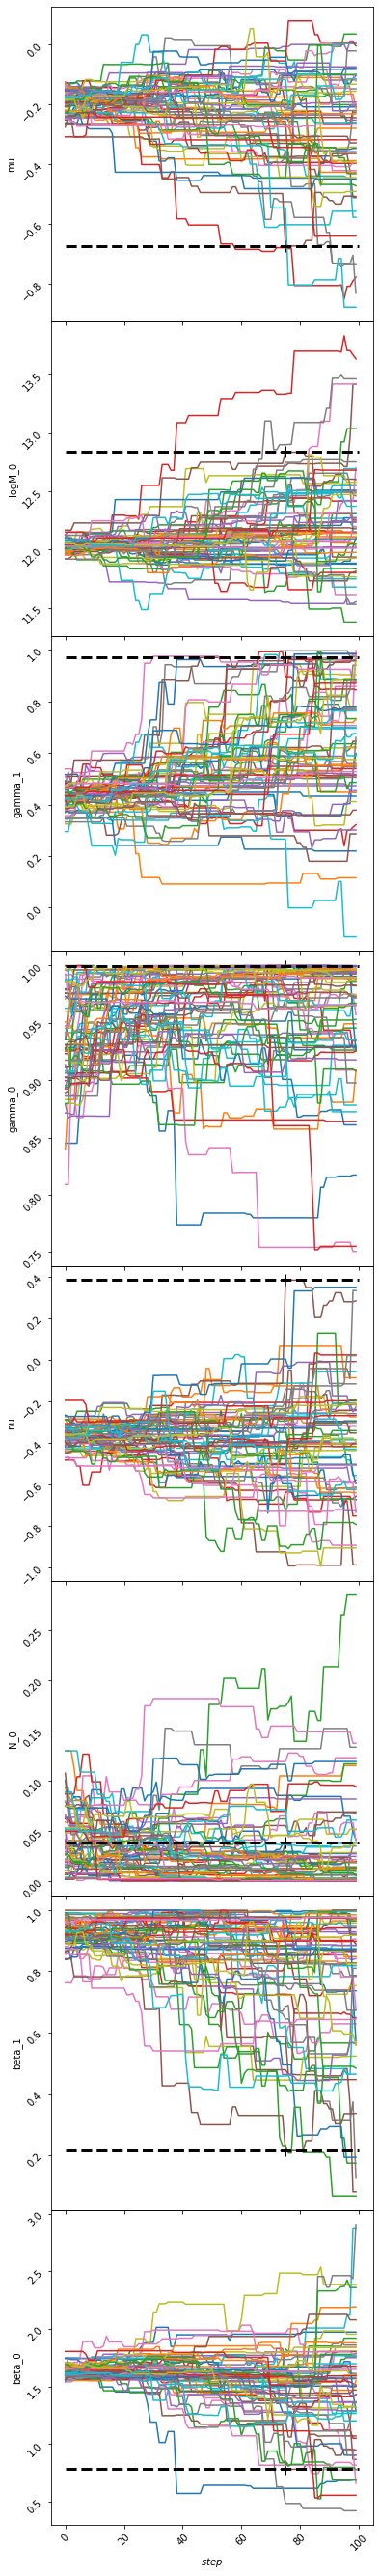

In [25]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [8]:
anl.max_likelihood_parameters()

4675
[[4675]
 [4676]
 [4677]
 [4678]
 [4679]
 [4975]
 [4976]]


{'pq_func_par0[0]': 0.7809805366315506,
 'pq_func_par2[0]': 0.21547840156832648,
 'pq_func_par0[1]': 0.038536250806780026,
 'pq_func_par2[1]': 0.38371394866185726,
 'pq_func_par0[2]': 0.9994848167152752,
 'pq_func_par2[2]': 0.9716965789333232,
 'pq_func_par0[3]': 12.835983543592212,
 'pq_func_par2[3]': -0.6735340049258653}

In [9]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.573998e+00
pq_func_par2[0]: 8.492150e-01
pq_func_par0[1]: 3.406284e-02
pq_func_par2[1]: -3.821738e-01
pq_func_par0[2]: 9.549756e-01
pq_func_par2[2]: 5.301701e-01
pq_func_par0[3]: 1.212199e+01
pq_func_par2[3]: -2.332157e-01


In [10]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [11]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

4675
[[4675]
 [4676]
 [4677]
 [4678]
 [4679]
 [4975]
 [4976]]
(0.7809805366315506, array([ 0.97703927, -0.61778609]))
(0.21547840156832648, array([ 0.7584589 , -0.53017323]))
(0.038536250806780026, array([0.0254519 , 0.03623118]))
(0.38371394866185726, array([-0.63997411,  0.91200879]))
(0.9994848167152752, array([-0.0039113,  0.0830274]))
(0.9716965789333232, array([-0.25380972,  0.59521108]))
(12.835983543592212, array([-0.52782505,  0.90635313]))
(-0.6735340049258653, array([ 0.54964966, -0.32754475]))


In [12]:
pars_best = ares.util.ParameterBundle("emma:model1")

print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 0.7809805366315506, 'pq_func_par2[0]': 0.21547840156832648, 'pq_func_par0[1]': 0.038536250806780026, 'pq_func_par2[1]': 0.38371394866185726, 'pq_func_par0[2]': 0.9994848167152752, 'pq_func_par2[2]': 0.9716965789333232, 'pq_func_par0[3]': 12.835983543592212, 'pq_func_par2[3]': -0.6735340049258653}


# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
[5.89960422e+01 6.23100588e+01 6.58102322e+01 ... 5.96308696e-30
 5.61521926e-30 5.28764506e-30]
Error, bin(s) out of interpolation bounds
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
Error, bin(s) out of interpolation bounds


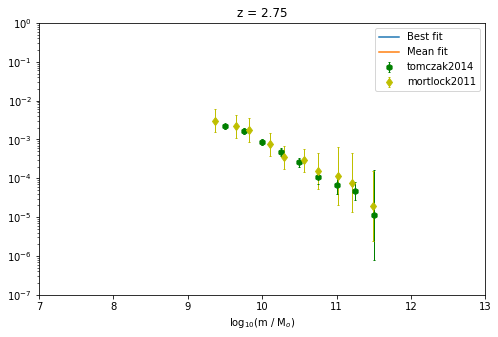

In [13]:
z = 2.75

fig, ax = pl.subplots(figsize=(8, 5))
Ms_short = np.linspace(7, 12, 80)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)

print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

# ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='lightskyblue', alpha=0.01, ax=ax)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

pl.semilogy(Ms_short, ls_best, label='Best fit')

pl.semilogy(Ms_short, ls_mean, label='Mean fit')

pl.title("z = %.2f" %z)
pl.xlabel("log$_{10}$(m / M$_o$)")
pl.legend()
# pl.ylim(1e-15, 1e2)
pl.show()

# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0000.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0001.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0002.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0003.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0004.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0005.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0006.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0007.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0008.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0009.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0010.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_20_07_08-20_0.0-5.0.dd0011.blob_1d.galaxy_sfrd.pkl
# Lo

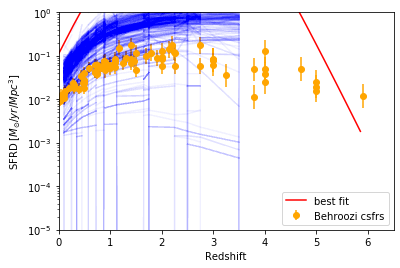

In [14]:
Zs = np.linspace(0, 7, 50)

import UsefulHODFunctions as UHF
csfrs, err = UHF.getCsfrsData()

ax = anl.ReconstructedFunction('galaxy_sfrd', ivar=None, samples='all', color='b', alpha=0.01)

SFRD_mod = pop_best.SFRD(Zs)
# print(SFRD_mod)

ax.semilogy(Zs, SFRD_mod, label="best fit", color='r')

ax.errorbar(csfrs[0], 10**csfrs[1], yerr=[err[0], err[1]], ls="", marker="o", color="orange", label="Behroozi csfrs" )

pl.ylabel('SFRD $[M_{\odot}/yr/Mpc^3]$')
pl.xlabel('Redshift')
pl.legend()

pl.ylim(1e-5, 1e0)
pl.xlim(0, 6.5)

pl.show()

1125.8159942999093
[1125.7874781839905 1125.7874781839905 1125.7874781839905
 1125.7874781839905 1125.7874781839905 1116.4462622126885
 1116.4462622126885 1116.4462622126885 1116.4462622126885
 1116.4462622126885 1125.8159942999093 1125.8159942999093
 1125.8159942999093 1125.8159942999093 1125.8159942999093
 1125.793023028045 1125.793023028045 1125.793023028045 1125.793023028045
 1125.793023028045]


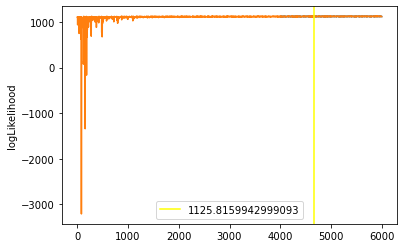

In [27]:
#loglikelihood
ticks = np.linspace(0, len(anl.logL)-1, len(anl.logL))

xstart = 4000

pl.plot(ticks[xstart:], anl.logL[xstart:])
pl.plot(ticks, anl.logL)

maxIn= 4675

maxL = anl.logL[maxIn]

print(anl.logL[maxIn])
print(anl.logL[maxIn-10:maxIn+10])

pl.axvline(x=maxIn, color="yellow", label=str(maxL))

pl.ylabel("logLikelihood")
# pl.ylim(1100,1160)
pl.legend()
pl.show()


In [14]:
def checkIfDuplicates_3(listOfElems):
    ''' Check if given list contains any duplicates '''    
    for elem in listOfElems:
        if listOfElems.count(elem) > 1:
            return True
    return -1

def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True

In [20]:
arr = np.array([0, 0.0, 0.00000, 1, 2, 4, 6, 7, 9])

np.count_nonzero(arr)

6

In [31]:
small = np.array([i < 9 for i in arr])

print(small)

if small.all():
    print("true")
else:
    print("false")

[ True  True  True  True  True  True  True  True False]
false


In [31]:
10**(np.log10(arr))

array([0., 0., 0., 1., 2., 4., 6., 7., 9.])